In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Define Resize Function

In [2]:
def resize(image, new_row, new_column):
    row, column = image.shape
    new_image = np.zeros((new_row, new_column), dtype=np.uint8)
    for i in range(new_row):
        for j in range(new_column):
            x = int(i * row / new_row)
            y = int(j * column / new_column)
            x = min(x, row - 1)
            y = min(y, column - 1)
            new_image[i, j] = image[x, y]
    return new_image

## Define Display Function

In [3]:
def display(data, labels, samples_per_label=5):
    unique_labels = np.unique(labels)
    num_unique_labels = len(unique_labels)

    plt.figure(figsize=(samples_per_label * 2, num_unique_labels * 2))

    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0]

        if len(indices) == 0:
            print(f"Tidak ada gambar ditemukan untuk label: {label}")
            continue

        selected_indices = indices[:samples_per_label]

        for j, idx in enumerate(selected_indices):
            plt.subplot(num_unique_labels, samples_per_label, i * samples_per_label + j + 1)
            plt.imshow(data[idx], cmap='gray')
            plt.axis('off')

            if j == 0:
                plt.title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

In [4]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = resize(img, 512, 512)
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

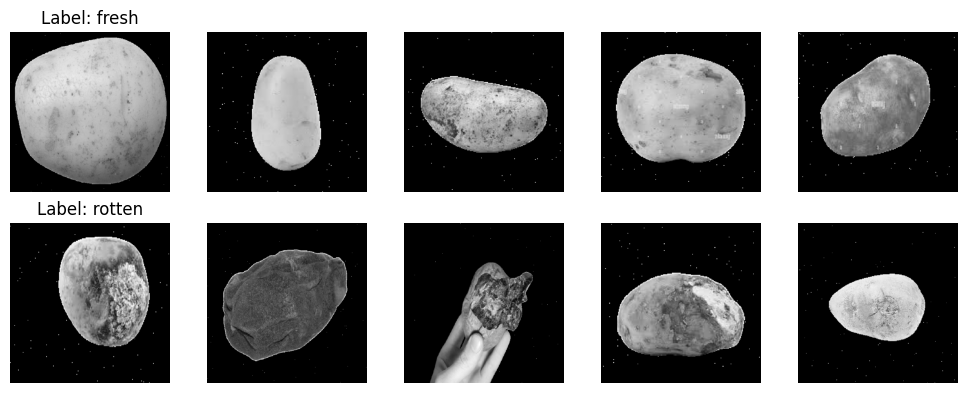

In [5]:
display(data, labels)

In [6]:
def median(image, size):
    paddedImage = np.pad(image, ((size//2, size//2), (size//2, size//2)), mode='edge')
    newImage = np.zeros(image.shape)

    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            area = paddedImage[y:y + size, x:x + size]
            values = area.flatten()
            sortedValues = sorted(values)
            medianValue = sortedValues[len(sortedValues) // 2]
            newImage[y, x] = medianValue
    return newImage

def normalisasi(image):
    baris, kolom = image.shape
    canvas = np.zeros_like(image)
    min_value = np.min(image)
    max_value = np.max(image)
    rentang = max_value - min_value

    for i in range(baris):
        for j in range(kolom):
            canvas[i,j] = ((image[i,j] - min_value) / rentang) * 255

    canvas = canvas.astype(np.uint8)
    return canvas

In [7]:
data_preprocessed = []
labels_preprocessed = []

for i in range(len(data)):
    img = data[i]
    lbl = labels[i]

    img_median = median(img, 3)
    img_norm = normalisasi(img_median)
    data_preprocessed.append(img_norm)
    labels_preprocessed.append(lbl)

data_preprocessed = np.array(data_preprocessed)
labels_preprocessed = np.array(labels_preprocessed)

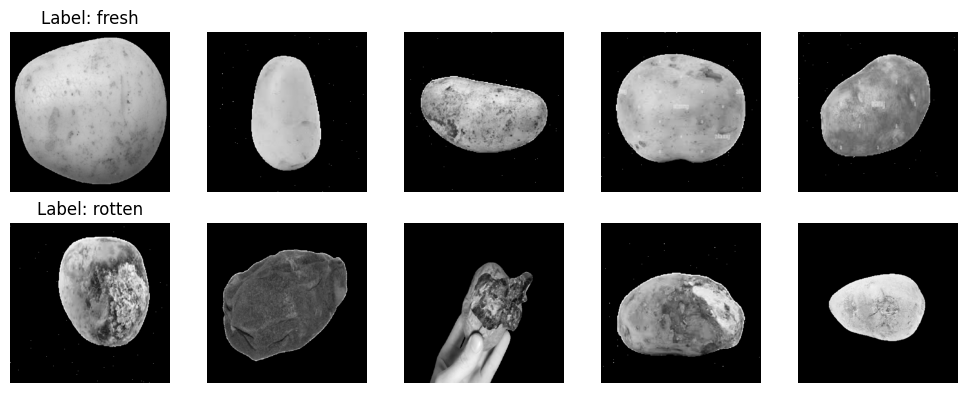

In [8]:
display(data_preprocessed, labels_preprocessed)

In [9]:
def glcm(image, derajat):
    if image.dtype != np.uint8 and image.dtype != np.uint16:
        image = (image * 255).astype(np.uint8)

    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")

    glcm = graycomatrix(image, [1], angles, levels=256, symmetric=True, normed=True)
    return glcm

In [10]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [11]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [12]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [13]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [14]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [15]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [16]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [17]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_preprocessed)):
    D0 = glcm(data_preprocessed[i], 0)
    D45 = glcm(data_preprocessed[i], 45)
    D90 = glcm(data_preprocessed[i], 90)
    D135 = glcm(data_preprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [18]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [19]:
for i in range(len(data_preprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [20]:
for i in range(len(data_preprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [21]:
for i in range(len(data_preprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [22]:
for i in range(len(data_preprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [23]:
for i in range(len(data_preprocessed)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [24]:
for i in range(len(data_preprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [25]:
for i in range(len(data_preprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [26]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,freshPotato (1).png,fresh,108.213697,168.330146,115.839913,165.977574,0.678701,0.618772,0.691175,0.623566,...,0.090872,0.089272,0.301393,0.298802,0.301449,0.298784,0.992608,0.988479,0.992087,0.988640
1,freshPotato (10).png,fresh,170.405379,198.595701,99.409292,208.685889,0.933812,0.913014,0.943586,0.915597,...,0.559776,0.557175,0.747518,0.746510,0.748182,0.746442,0.988142,0.986197,0.993082,0.985496
2,freshPotato (11).png,fresh,121.166341,207.263736,167.370719,227.719272,0.857938,0.817971,0.853182,0.819212,...,0.503209,0.501540,0.710016,0.708438,0.709373,0.708195,0.989792,0.982560,0.985900,0.980839
3,freshPotato (12).png,fresh,161.410783,226.872553,146.227373,222.899560,0.843490,0.778820,0.828498,0.781051,...,0.300898,0.298789,0.548678,0.546632,0.548542,0.546616,0.990026,0.985986,0.990964,0.986232
4,freshPotato (13).png,fresh,126.147845,211.421192,136.031816,162.133145,0.851087,0.811981,0.862072,0.814264,...,0.450497,0.449061,0.671471,0.669598,0.671191,0.670120,0.986647,0.977645,0.985602,0.982857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,rottenPotato (73).png,rotten,134.824456,162.010436,133.919570,253.895324,0.758816,0.739470,0.757278,0.727749,...,0.375716,0.373723,0.612372,0.611989,0.612957,0.611329,0.988594,0.986300,0.988664,0.978530
146,rottenPotato (74).png,rotten,52.598830,90.480555,58.499992,93.380207,0.712913,0.680130,0.708060,0.680900,...,0.373093,0.372190,0.611542,0.609852,0.610813,0.610074,0.993613,0.989024,0.992898,0.988672
147,rottenPotato (75).png,rotten,51.705120,79.107027,45.506941,80.717560,0.729924,0.712083,0.733007,0.710346,...,0.381481,0.380150,0.618036,0.616342,0.617642,0.616563,0.994371,0.991395,0.995045,0.991220
148,rottenPotato (8).png,rotten,84.701688,125.650377,72.388492,108.947408,0.803021,0.779478,0.815606,0.780559,...,0.497861,0.496292,0.705523,0.704285,0.705593,0.704480,0.987341,0.981244,0.989181,0.983737


<Axes: >

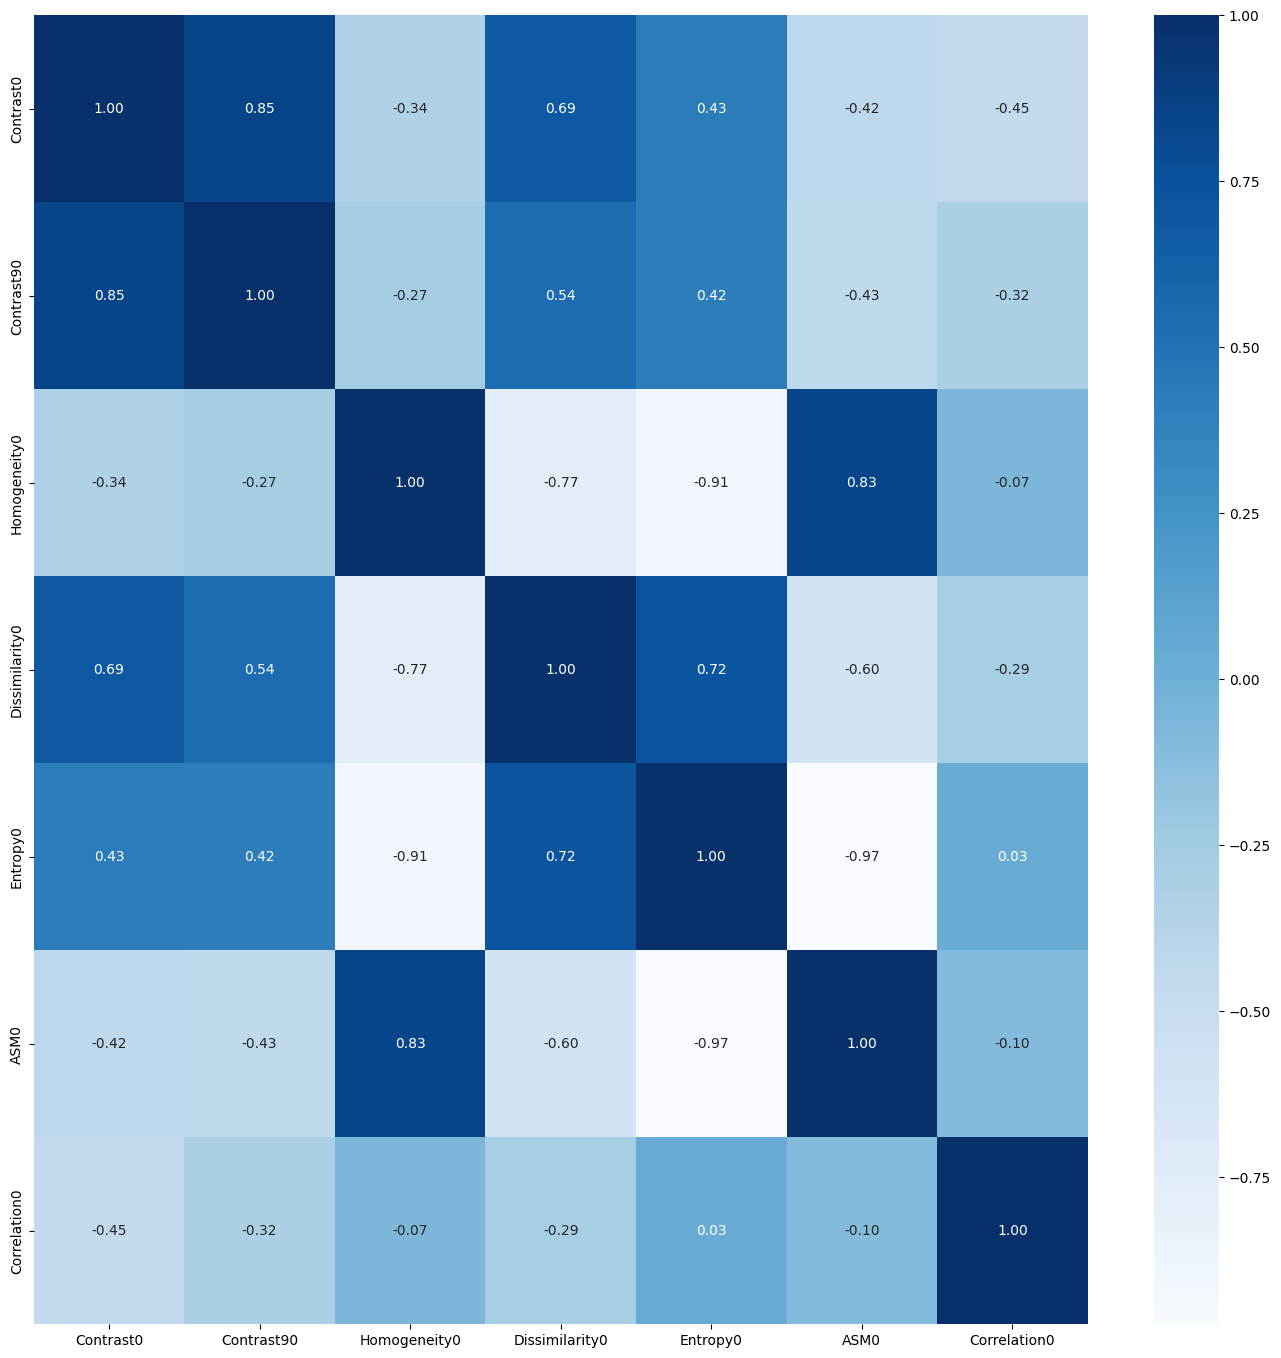

In [27]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [28]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(105, 7)
(45, 7)


In [29]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [30]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [31]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       fresh       0.98      1.00      0.99        48
      rotten       1.00      0.98      0.99        57

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105

[[48  0]
 [ 1 56]]
Accuracy: 0.9904761904761905

------Testing Set------
              precision    recall  f1-score   support

       fresh       0.92      0.85      0.88        27
      rotten       0.80      0.89      0.84        18

    accuracy                           0.87        45
   macro avg       0.86      0.87      0.86        45
weighted avg       0.87      0.87      0.87        45

[[23  4]
 [ 2 16]]
Accuracy: 0.8666666666666667


In [32]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.91      0.81      0.86        48
      rotten       0.85      0.93      0.89        57

    accuracy                           0.88       105
   macro avg       0.88      0.87      0.87       105
weighted avg       0.88      0.88      0.88       105

[[39  9]
 [ 4 53]]
Accuracy: 0.8761904761904762

------Testing Set------
              precision    recall  f1-score   support

       fresh       0.95      0.78      0.86        27
      rotten       0.74      0.94      0.83        18

    accuracy                           0.84        45
   macro avg       0.85      0.86      0.84        45
weighted avg       0.87      0.84      0.85        45

[[21  6]
 [ 1 17]]
Accuracy: 0.8444444444444444


In [33]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       fresh       0.93      0.77      0.84        48
      rotten       0.83      0.95      0.89        57

    accuracy                           0.87       105
   macro avg       0.88      0.86      0.86       105
weighted avg       0.87      0.87      0.86       105

[[37 11]
 [ 3 54]]
Accuracy: 0.8666666666666667

------Testing Set------
              precision    recall  f1-score   support

       fresh       0.92      0.81      0.86        27
      rotten       0.76      0.89      0.82        18

    accuracy                           0.84        45
   macro avg       0.84      0.85      0.84        45
weighted avg       0.85      0.84      0.85        45

[[22  5]
 [ 2 16]]
Accuracy: 0.8444444444444444


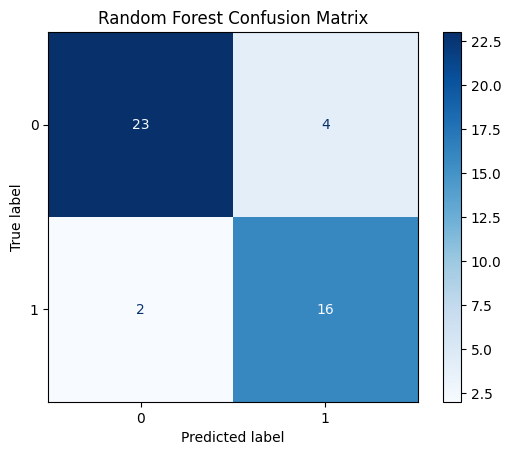

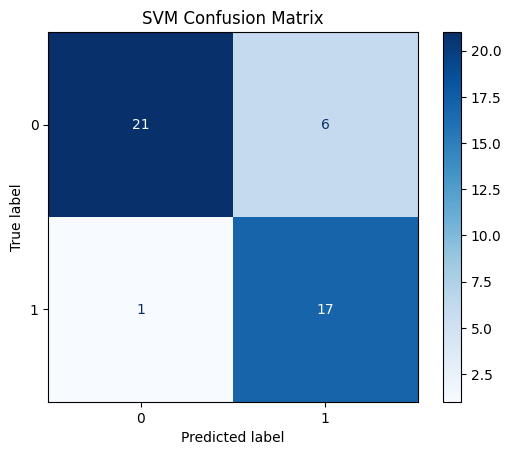

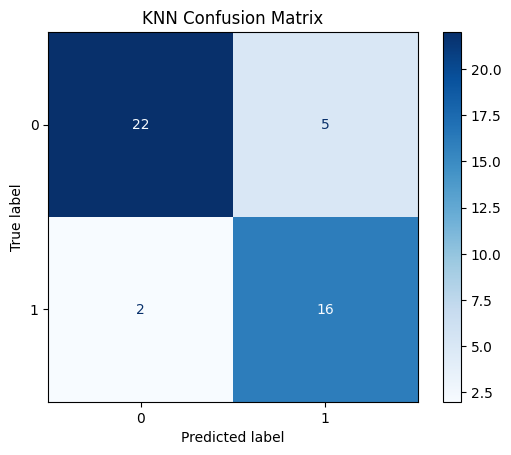

In [34]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")